In [53]:
""" Desinstalamos la version por defecto de google colab de sklearn para instalar la ultima version """
# es necesario esta version para poder descargar fetch_kddcup99 
# con el parametro as_frame=True disponible en la version 0.24

!pip uninstall scikit-learn -y
!pip install -U scikit-learn

Uninstalling scikit-learn-0.24.2:
  Successfully uninstalled scikit-learn-0.24.2
  Using cached https://files.pythonhosted.org/packages/a8/eb/a48f25c967526b66d5f1fa7a984594f0bf0a5afafa94a8c4dbc317744620/scikit_learn-0.24.2-cp37-cp37m-manylinux2010_x86_64.whl


In [1]:
""" Comprobamos la version de  sklearn """

import sklearn
sklearn.__version__

'0.24.2'

In [3]:
""" Cualquier librería adicional que necesiteis durante el ejercicio, importadlo en esta sección """

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_style('darkgrid')
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


# Ejercicio 2

Este ejercicio pretende poner en práctica la habilidad de limpiar datos y visualizar plots en para crear finalmente modelos en __sklearn__.

El estudiante tendrá que repasar los comandos realizados en clase y lidiar con posibles errores durante el desarrollo. 

Para facilitar y agilizar el desarrollo, el estudiante tendrá que rellenar los huecos marcados como '_# codigo-alumno_'. No obstante, si además el estudiante necesita ejecutar código adicional, siempre podrá utilizar cualquier celda adicional. 

El estudiante tendrá siempre que introducir una semilla (seed) que generará acorde a su fecha de nacimiento (sin ser intrusivos en edad).

Finalmente, la entrega será un fichero .ipynb cambiando nombre y apellido al fichero.

In [4]:
""" El estudiante tendrá que utilizar la semilla proporcionada para todos los procesos aleatorios """

# dia-nacimiento-estudiante + 13 * mes-nacimiento-estudiante
seed = 30 + 13 * 9

### Data cleansing

In [5]:
""" Leed el dataframe de sklearn llamado 'fetch_kddcup99' y almacenarlo en una variable llamada data """

from sklearn.datasets import fetch_kddcup99

data = fetch_kddcup99(as_frame=True)
pd_data = data.frame
pd_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,b'tcp',b'http',b'SF',181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0,0,0,0,1,0,0,9,9,1,0,0.11,0,0,0,0,0,b'normal.'
1,0,b'tcp',b'http',b'SF',239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0,0,0,0,1,0,0,19,19,1,0,0.05,0,0,0,0,0,b'normal.'
2,0,b'tcp',b'http',b'SF',235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0,0,0,0,1,0,0,29,29,1,0,0.03,0,0,0,0,0,b'normal.'
3,0,b'tcp',b'http',b'SF',219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0,0,0,0,1,0,0,39,39,1,0,0.03,0,0,0,0,0,b'normal.'
4,0,b'tcp',b'http',b'SF',217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0,0,0,0,1,0,0,49,49,1,0,0.02,0,0,0,0,0,b'normal.'


In [6]:
""" De entre todas las variables del dataframe, solo trabajaremos en 
    este ejercicio con las descritas en key_columns, por lo que tendréis que quitar el resto """

key_columns = ['duration', 'protocol_type', 'service', 'flag', 'logged_in', 'count', 'srv_count', 'serror_rate', 'dst_host_srv_count', 'dst_host_srv_serror_rate', 'labels']

pd_data = pd_data[key_columns]
pd_data.head()

,duration,protocol_type,service,flag,logged_in,count,srv_count,serror_rate,dst_host_srv_count,dst_host_srv_serror_rate,labels
0,0,b'tcp',b'http',b'SF',1,8,8,0,9,0,b'normal.'
1,0,b'tcp',b'http',b'SF',1,8,8,0,19,0,b'normal.'
2,0,b'tcp',b'http',b'SF',1,8,8,0,29,0,b'normal.'
3,0,b'tcp',b'http',b'SF',1,6,6,0,39,0,b'normal.'
4,0,b'tcp',b'http',b'SF',1,6,6,0,49,0,b'normal.'


In [7]:
""" Comprobad que no haya nulos ni registros duplicados """

# codigo-alumno
pd_data.isnull().sum()

duration                    0
protocol_type               0
service                     0
flag                        0
logged_in                   0
count                       0
srv_count                   0
serror_rate                 0
dst_host_srv_count          0
dst_host_srv_serror_rate    0
labels                      0
dtype: int64

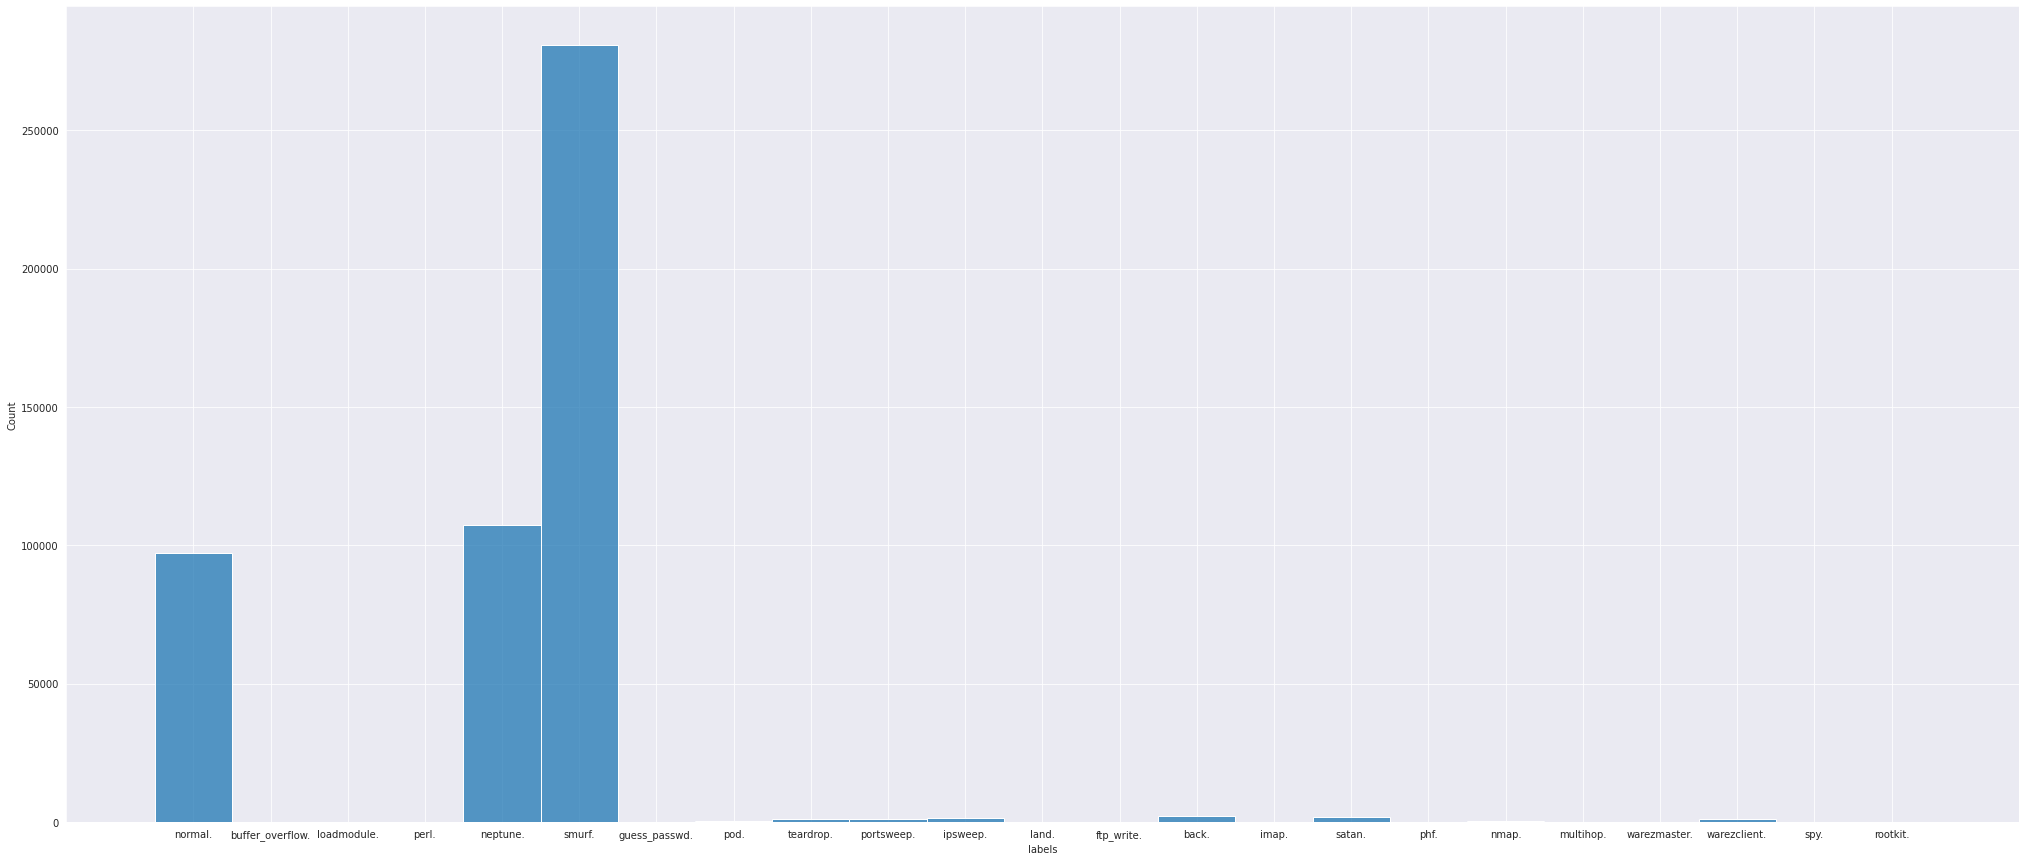

In [8]:
""" Mostrar un barplot para la variable objetivo (labels)"""

target = 'labels'

# codigo-alumno
plt.figure(figsize=(35,15))
sns.histplot(x=target, data=pd_data, kde=False)
plt.show()

In [9]:
""" Dado que hay dos etiquetas que se repiten con mayor frecuencia, 
    transformad la variable labels para que tenga un valor booleano que indique 
    si es la etiqueta más frecuente o la segunda más frecuente, 
    los demás registros los eliminaremos de este estudio """

# pese a que b'normal.' tiene un numero similar de observaciones que neptune no 
# la tenemos en cuenta ya que los criterios del ejercicio exigen un booleano
# mas frecuente   : b'smurf.'   --->    280790  (True)  (1)
# menos frecuente : b'neptune.' --->    107201  (False) (0)

# codigo-alumno
pd_data = pd_data[pd_data.labels.isin([ b'neptune.', b'smurf.'])]
pd_data['labels'] = pd_data.labels.apply(lambda x: 1 if x == b'smurf.' else 0) # TERMINAR

print(len(pd_data))
pd_data.groupby('labels').size().sort_values(ascending=False)

387991


labels
1    280790
0    107201
dtype: int64

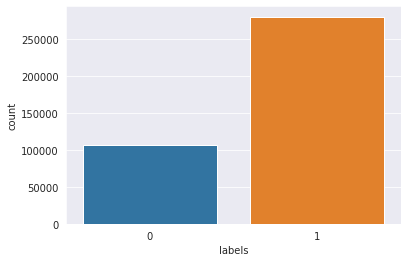

In [10]:
""" Volved a mostrar el barplot para la variable objetivo (labels) """

# codigo-alumno
sns.countplot(pd_data[target])
plt.show()

In [11]:
""" Separaremos las variables categóricas de las numéricas """


num_cols = ['duration', 'count', 'srv_count', 'serror_rate', 'dst_host_srv_count', 'dst_host_srv_serror_rate']
cat_cols = ['protocol_type', 'service', 'flag', 'logged_in']

pd_data[num_cols] = pd_data[num_cols].astype(float)

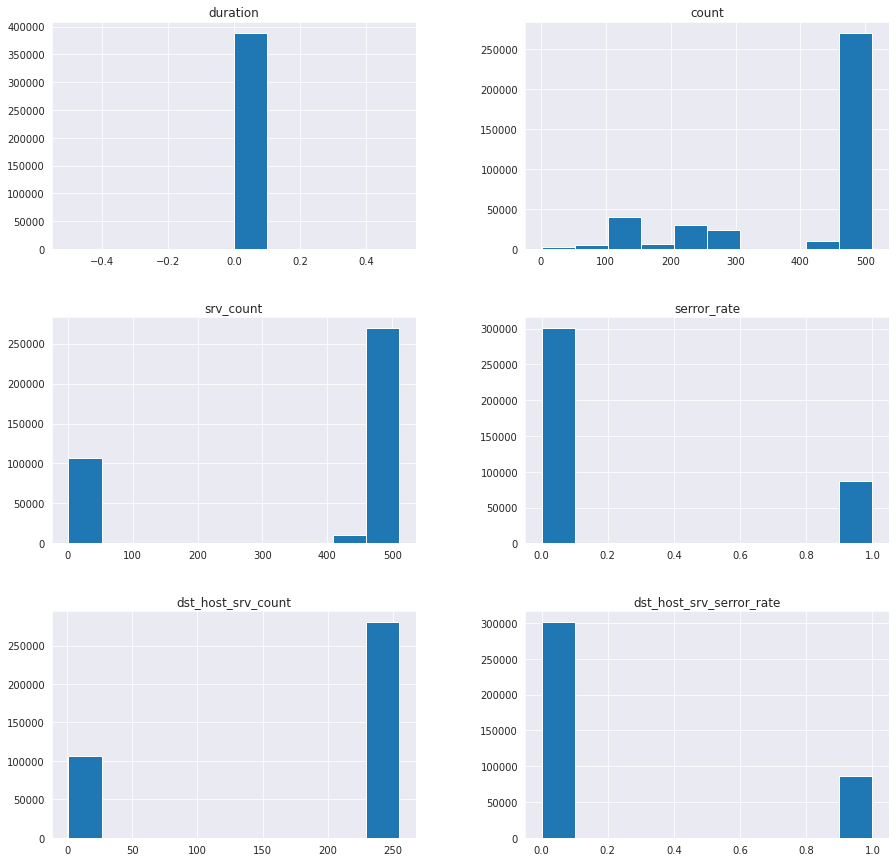

In [12]:
""" Mostrad un histograma por cada variable numérica """

# codigo-alumno
pd_data_num = pd_data[num_cols]

pd_data_num.hist(figsize=(15,15))
plt.show()

In [13]:
pd_data_num.describe()

,duration,count,srv_count,serror_rate,dst_host_srv_count,dst_host_srv_serror_rate
count,387991.0,387991.000000,387991.000000,387991.000000,387991.000000,387991.000000
mean,0.0,419.047800,369.974538,0.223537,187.525360,0.223532
std,0.0,147.766464,222.383124,0.416584,109.162474,0.416592
min,0.0,1.000000,1.000000,0.000000,1.000000,0.000000
25%,0.0,278.000000,19.000000,0.000000,19.000000,0.000000
50%,0.0,511.000000,511.000000,0.000000,255.000000,0.000000
75%,0.0,511.000000,511.000000,0.000000,255.000000,0.000000
max,0.0,511.000000,511.000000,1.000000,255.000000,1.000000


In [14]:
pd_data_num.duration.sum()

0.0

In [15]:
""" Por la forma de los histogramas, podría ser un buen estudio convertir las variables
    numéricas a variables dummy, es lo que hareis en este apartado y, por tanto, pasarán 
    a ser categóricas todas las variables del dataframe. Esta parte será libre para el 
    estudiante. Deberá tomar la decisión que considere más apropiada para realizar esta 
    binarización """


# codigo-alumno

# en el caso de count he decidido descartar la variable, ya que el todos los valores 
# son 0 y no aporta ninguna informacion al modelo
# pd_data.drop(['duration'], axis=1) # no necesario ya que lo haremos al omitir la columna mas tarde
# quitamos duration de num_cols 
num_cols = ['count', 'srv_count', 'serror_rate', 'dst_host_srv_count', 'dst_host_srv_serror_rate']


# Todas las variables he decidido separarlas en dos grupos, 
# por lo tanto utilizamos booleanos para darle caracter binario
pd_data['count'] = pd_data['count'].apply(lambda x: 0 if x<500 else 1)  # True valores mayores de 500
pd_data['srv_count'] = pd_data['srv_count'].apply(lambda x: 0 if x<500 else 1)  # True valores mayores de 500
pd_data['serror_rate'] = pd_data['serror_rate'].apply(lambda x: 0 if x<0.5 else 1) # True valores cecanos a 1
pd_data['dst_host_srv_count'] = pd_data['dst_host_srv_count'].apply(lambda x: 0 if x<250 else 1) # True valores mayores de 250
pd_data['dst_host_srv_serror_rate'] = pd_data['dst_host_srv_serror_rate'].apply(lambda x: 0 if x<0.5 else 1) # True valores cecanos a 1


In [16]:
pd_data.head()

,duration,protocol_type,service,flag,logged_in,count,srv_count,serror_rate,dst_host_srv_count,dst_host_srv_serror_rate,labels
7601,0.0,b'tcp',b'telnet',b'S0',0,0,0,1,0,1,0
7602,0.0,b'tcp',b'telnet',b'S0',0,0,0,1,0,1,0
7793,0.0,b'icmp',b'ecr_i',b'SF',0,0,0,0,0,0,1
7794,0.0,b'icmp',b'ecr_i',b'SF',0,1,1,0,0,0,1
7795,0.0,b'icmp',b'ecr_i',b'SF',0,1,1,0,0,0,1


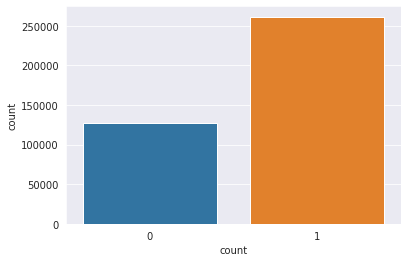

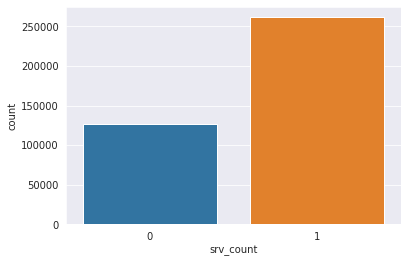

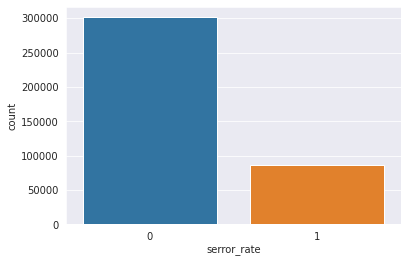

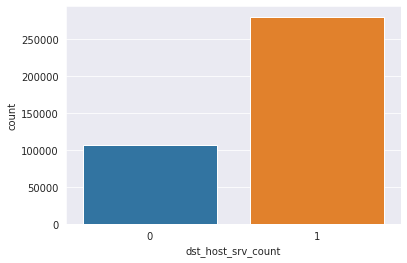

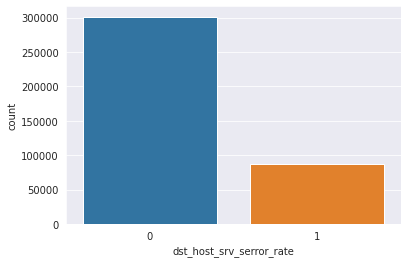

In [17]:
""" Histograma del las numericas convertidas a categoricas binarias """

pd_data_num = pd_data[num_cols]

for col in num_cols:
    sns.countplot(pd_data_num[col])
    plt.show()

In [18]:
# added
# juntamos todas las columnas o features
num_cols = ['count', 'srv_count', 'serror_rate', 'dst_host_srv_count', 'dst_host_srv_serror_rate']
cols = num_cols + cat_cols

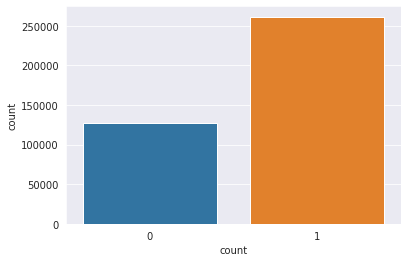

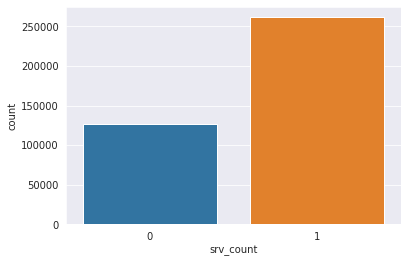

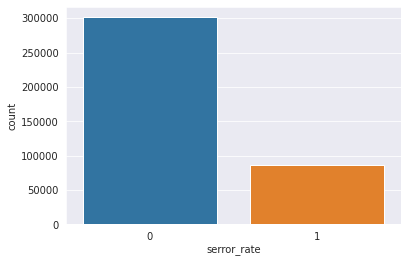

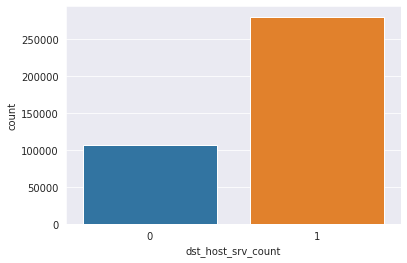

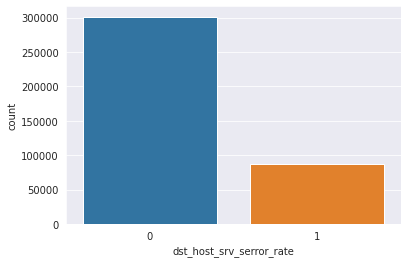

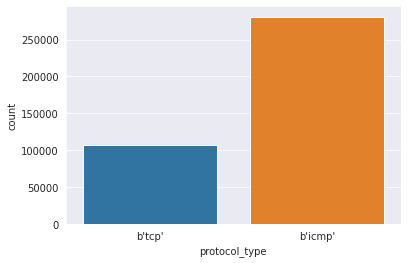

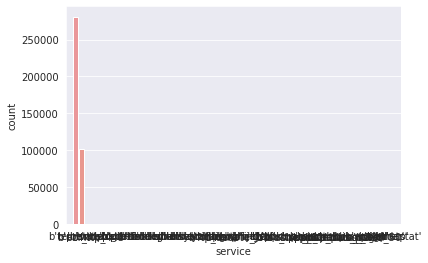

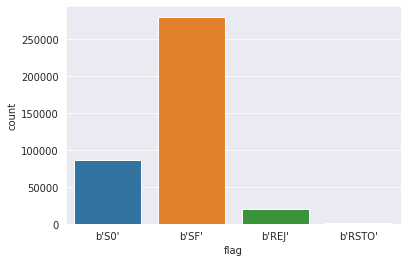

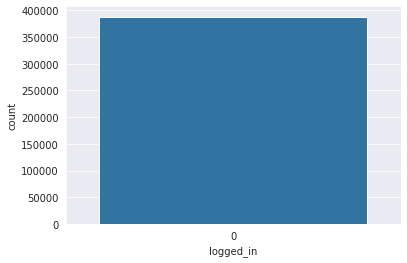

In [19]:
""" Mostrad un barplot por cada variable """

# codigo-alumno
for col in cols:
    sns.countplot(pd_data[col])
    plt.show()

In [20]:
pd_data.head()

,duration,protocol_type,service,flag,logged_in,count,srv_count,serror_rate,dst_host_srv_count,dst_host_srv_serror_rate,labels
7601,0.0,b'tcp',b'telnet',b'S0',0,0,0,1,0,1,0
7602,0.0,b'tcp',b'telnet',b'S0',0,0,0,1,0,1,0
7793,0.0,b'icmp',b'ecr_i',b'SF',0,0,0,0,0,0,1
7794,0.0,b'icmp',b'ecr_i',b'SF',0,1,1,0,0,0,1
7795,0.0,b'icmp',b'ecr_i',b'SF',0,1,1,0,0,0,1


In [21]:
""" Transformad la variable service en una variable dummy que nos permitan identificar el servicio
    más frecuente frente al resto """

# codigo-alumno
# decodificamos la cadena en bytes to string
pd_data['service'] = pd_data['service'].apply(lambda x: x.decode("utf-8") if x in [b'ecr_i', b'private'] else 'Other')

pd_data.groupby('service').size().sort_values(ascending=False)

service
ecr_i      280790
private    101317
Other        5884
dtype: int64

In [22]:
""" Transformad la variable flag en dos variables dummy que nos permitan identificar 3 tipos de flags, 
    los dos más comunes y el resto """

# codigo-alumno
pd_data['flag'] = pd_data['flag'].apply(lambda x: x.decode("utf-8") if x in [b'S0', b'SF'] else 'Other')

pd_data.groupby('flag').size().sort_values(ascending=False)

flag
SF       280790
S0        86744
Other     20457
dtype: int64

In [23]:
# added
""" Decodificamos los bytes object a string con la feature: protocol_type """

pd_data['protocol_type'] = pd_data['protocol_type'].apply(lambda x: x.decode("utf-8"))

In [24]:
# added
""" La variable logged_in no aporta informacion ya que siempre muestra el mismo valor y la eliminamos """

#pd_data.drop(['logged_in'], axis=1) # no necesario omitimos la columna a continuacion
cat_cols = ['protocol_type', 'service', 'flag']

In [25]:
#added
cols = num_cols + cat_cols + [target]
# eliminamos las columnas omitidas
pd_data = pd_data[cols]

In [26]:
pd_data.head()

,count,srv_count,serror_rate,dst_host_srv_count,dst_host_srv_serror_rate,protocol_type,service,flag,labels
7601,0,0,1,0,1,tcp,Other,S0,0
7602,0,0,1,0,1,tcp,Other,S0,0
7793,0,0,0,0,0,icmp,ecr_i,SF,1
7794,1,1,0,0,0,icmp,ecr_i,SF,1
7795,1,1,0,0,0,icmp,ecr_i,SF,1


In [27]:
# added
""" Aplicamos panda.get_dummies """

pd_data = pd.get_dummies(pd_data)

In [28]:
pd_data.head()

,count,srv_count,serror_rate,dst_host_srv_count,dst_host_srv_serror_rate,labels,protocol_type_icmp,protocol_type_tcp,service_Other,service_ecr_i,service_private,flag_Other,flag_S0,flag_SF
7601,0,0,1,0,1,0,0,1,1,0,0,0,1,0
7602,0,0,1,0,1,0,0,1,1,0,0,0,1,0
7793,0,0,0,0,0,1,1,0,0,1,0,0,0,1
7794,1,1,0,0,0,1,1,0,0,1,0,0,0,1
7795,1,1,0,0,0,1,1,0,0,1,0,0,0,1


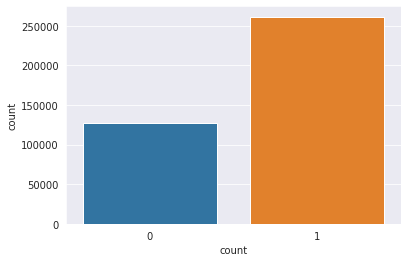

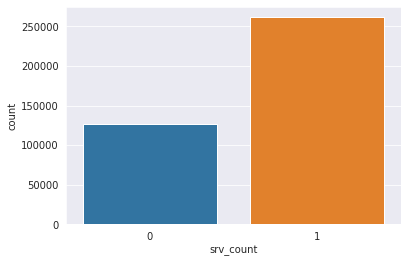

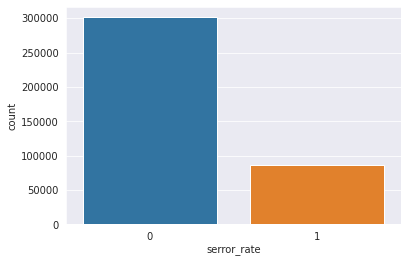

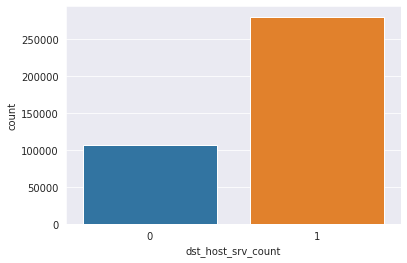

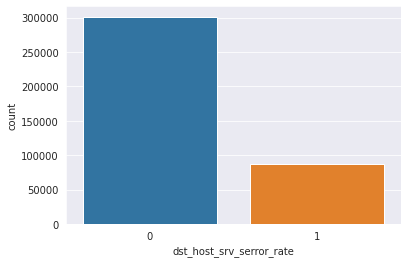

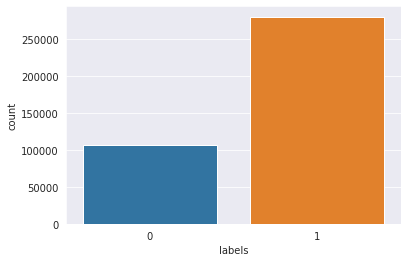

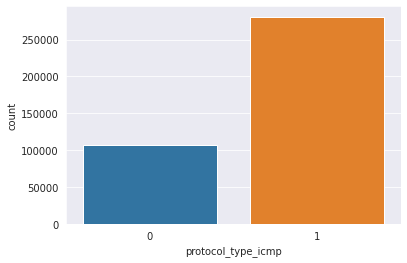

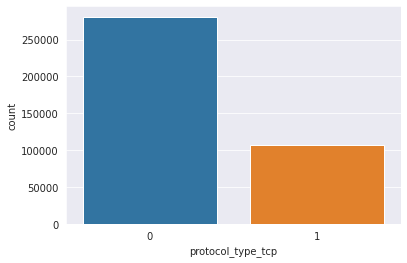

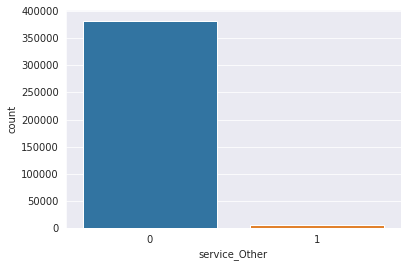

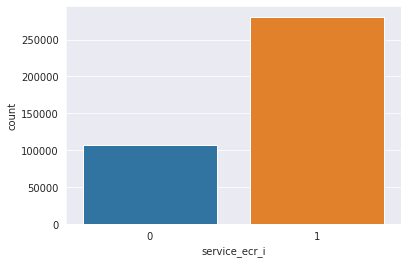

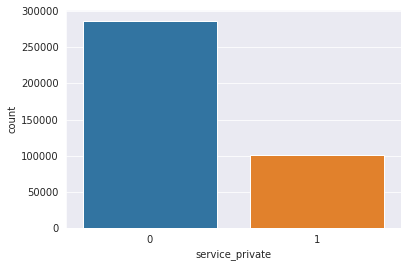

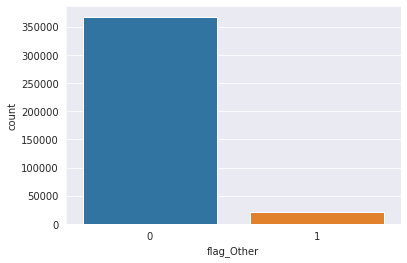

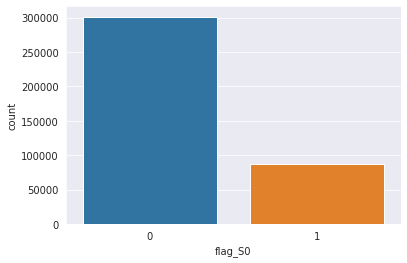

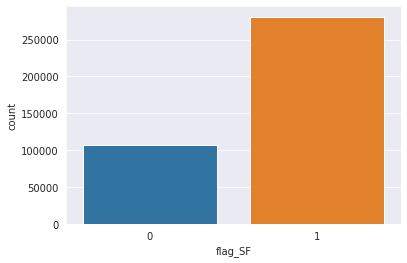

In [29]:
""" Volved a mostrad un barplot por cada variable """

# codigo-alumno
for col in pd_data.columns:
    sns.countplot(pd_data[col])
    plt.show()

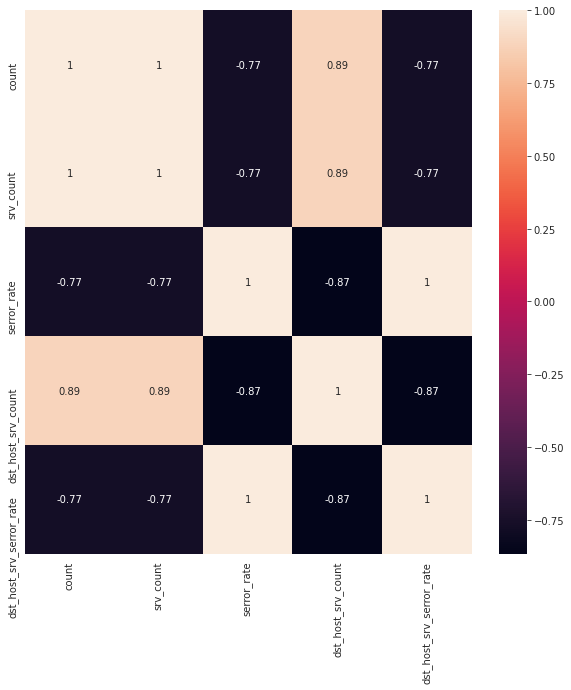

In [30]:
""" Mostrad un plot de correlaciones entre variables numéricas """

# codigo-alumno
plt.figure(figsize=(10,10))
sns.heatmap(pd_data[num_cols].corr(), annot=True)
plt.show()

In [31]:
# tenemos datos correlacionados y deberiamos eliminarlos, para ello utilizaremos
# tecnicas de seleccion de variables a continuacion

### Model evaluation

In [32]:
""" Realizad una evaluación de, al menos, cinco modelos de machine learning con
    la técnica de validación cruzada más acertada (10 splits). Además, se pide
    incorporar, al menos, una técnica de selección previa de las 1, 2 o 3 features que
    mejores resultados ofrezca (Nota, tendreis que usar OneHotEncoder para las variables 
    que tengan strings) """

X = pd_data.drop(target, axis=1) 
y = pd_data[target]

# codigo-alumno
# añadimos los modelos, al menos 5, pero usamos los 7 propuestos por el profesor en clase 
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier(random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('RFC', RandomForestClassifier(random_state=seed)))
models.append(('SVM', SVC()))


In [33]:
# added
""" Para plotear los resultados utilizaremos la siguiente función """

def boxplots_algorithms(results, names):
    
    plt.figure(figsize=(8,8))
    plt.boxplot(results)
    plt.xticks(range(1,len(names)+1), names)
    plt.show()

In [38]:
# added
""" Como se pide en el ejercicio:
    - Técnica de validación cruzada más acertada (10 splits) ### KFold
    - Técnica de selección previa de las 1, 2 o 3 features que mejores resultados ofrezca
    - OneHotEncoder ### Este paso no es necesario por que previamente se uso panda.get_dummies para todo el df
"""

# este codigo se usara para elegir las 3 variables mas importantes he seleccionado 3
# debido a la gran correlacion entre todas la features
test = SelectKBest(score_func=chi2, k=3)
fit = test.fit(X,y)

X_transformed = fit.transform(X) # 3 features mas importantes
fit.scores_

array([ 99792.49,  99792.49, 227207.28, 107124.64, 227170.61, 107201.  ,
       280790.  ,  15411.87, 107201.  , 265378.13,  53582.72, 227207.28,
       107201.  ])

LR: 1.000000 (0.000000)
LDA: 0.984835 (0.000594)
KNN: 1.000000 (0.000000)
DTC: 1.000000 (0.000000)
NB: 1.000000 (0.000000)
RFC: 1.000000 (0.000000)
SVM: 1.000000 (0.000000)


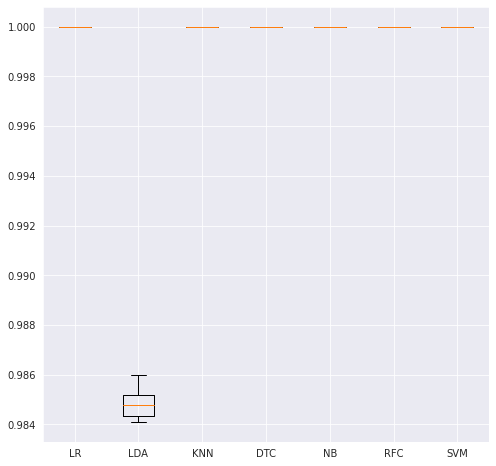

In [ ]:
# added
""" Como se pide en el ejercicio:
    - Técnica de validación cruzada más acertada (10 splits) 
    - Técnica de selección previa de las 1, 2 o 3 features que mejores resultados ofrezca ### Code anterior
    - OneHotEncoder ### Este paso no es necesario por que previamente se uso panda.get_dummies para todo el df
"""

results = []
names = []

for name, model in models:
    
    cv_technique = KFold(n_splits=10, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_transformed, y, cv=cv_technique, scoring='accuracy')
    
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
    results.append(cv_results)
    names.append(name)
    
boxplots_algorithms(results, names)

In [37]:
# added
""" Como se pide en el ejercicio:
    - Técnica de validación cruzada más acertada (10 splits) ### StratifiedKFold 
    - Técnica de selección previa de las 1, 2 o 3 features que mejores resultados ofrezca ### 2
    - OneHotEncoder ### Este paso no es necesario por que previamente se uso panda.get_dummies para todo el df
"""

# este codigo se usara para elegir las 3 variables mas importantes he seleccionado 3
# debido a la gran correlacion entre todas la features
test = SelectKBest(score_func=chi2, k=2)
fit = test.fit(X,y)

X_transformed = fit.transform(X) # 3 features mas importantes
fit.scores_

array([ 99792.49,  99792.49, 227207.28, 107124.64, 227170.61, 107201.  ,
       280790.  ,  15411.87, 107201.  , 265378.13,  53582.72, 227207.28,
       107201.  ])

LR: 1.000000 (0.000000)
LDA: 0.984835 (0.000406)
KNN: 1.000000 (0.000000)
DTC: 1.000000 (0.000000)
NB: 1.000000 (0.000000)
RFC: 1.000000 (0.000000)
SVM: 1.000000 (0.000000)


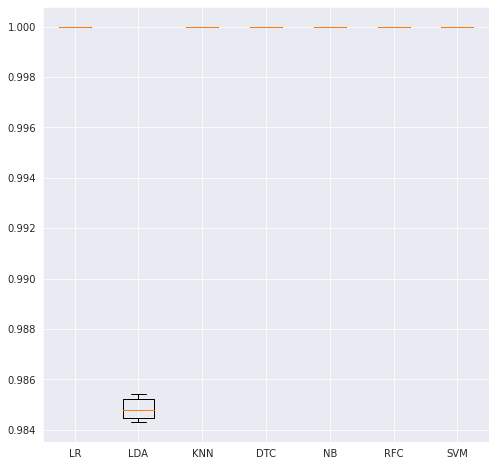

In [35]:
# added
""" Como se pide en el ejercicio:
    - Técnica de validación cruzada más acertada (10 splits) 
    - Técnica de selección previa de las 1, 2 o 3 features que mejores resultados ofrezca ### Code anterior
    - OneHotEncoder ### Este paso no es necesario por que previamente se uso panda.get_dummies para todo el df
"""

results = []
names = []

for name, model in models:
    
    cv_technique = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_transformed, y, cv=cv_technique, scoring='accuracy')
    
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
    results.append(cv_results)
    names.append(name)
    
boxplots_algorithms(results, names)

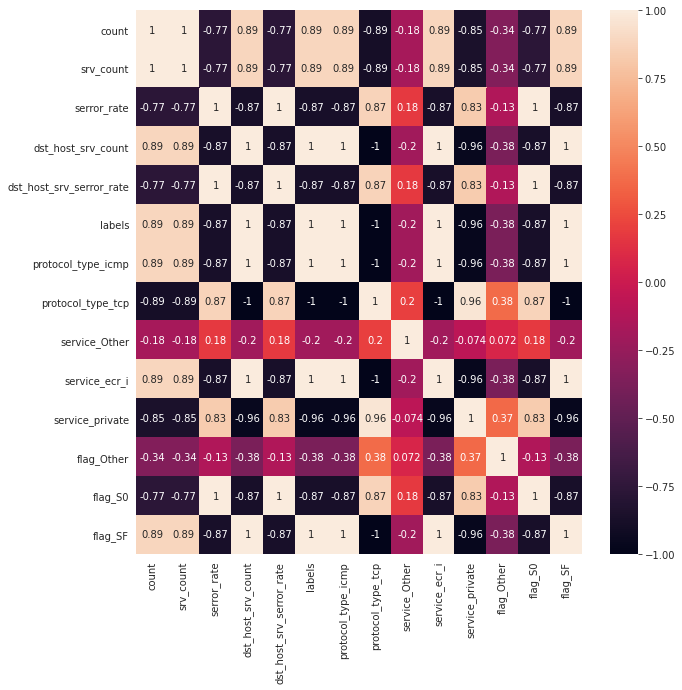

In [ ]:
# added
""" Mostrad un plot de correlaciones entre variables """

plt.figure(figsize=(10,10))
sns.heatmap(pd_data.corr(), annot=True)
plt.show()

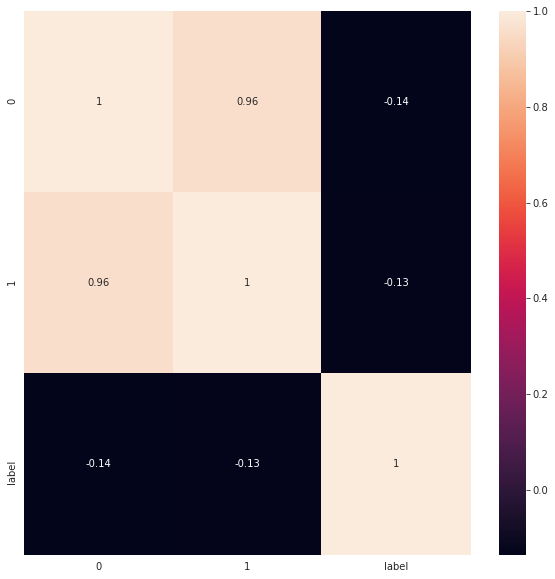

In [36]:
# added
""" Mostrad un plot de correlaciones entre variables seleccionadas """

pd_data_model = pd.DataFrame(X_transformed)
pd_data_model['label'] = pd.DataFrame(y)

plt.figure(figsize=(10,10))
sns.heatmap(pd_data_model.corr(), annot=True)
plt.show()

In [39]:
# como podemos ver en el grafico de correlacion la bariable objetivo "label" 
# está altamente correlacionada con todas las variables, por ello, 
# casi todos los modelos obtienen un accuraccy del 100% en el dataset

# otra opcion podria ser dividir el dataset original en train y test y generar el 
# modelo con los datos train y comprobar el acuraccy con el test, 
# aun que esto ya lo hace internamente las tecnicas de validacion cruzada aplicadas